In [1]:
import pandas as pd
import numpy as np

In [2]:
img_dir = './cassava-leaf-disease-classification'

In [3]:
from os import listdir
from PIL import Image as PImage
import cv2

In [4]:
for image in listdir(img_dir):
    print(image)

label_num_to_disease_map.json
sample_submission.csv
test_images
test_tfrecords
train.csv
train_images
train_tfrecords


In [5]:
train_data = pd.read_csv(img_dir+'/train.csv')

In [6]:
train_data.head(10)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
5,1000837476.jpg,3
6,1000910826.jpg,2
7,1001320321.jpg,0
8,1001723730.jpg,4
9,1001742395.jpg,3


In [7]:
zero = []
one = []
two = []
three = []
four = []
for i in listdir(img_dir+'/train_images'):
    for x,y in zip(train_data['image_id'],train_data['label']):
        if i == x:
            if y == 0:
                zero.append(i)
            elif y == 1:
                one.append(i)
            elif y == 2:
                two.append(i)
            elif y == 3:
                three.append(i)
            elif y == 4:
                four.append(i)
            else:
                print('somthing went wrong')

In [8]:
print(len(zero),len(one),len(two),len(three),len(four))

1087 2189 2386 13158 2577


In [9]:
zero_img = []
for i in zero:
    zero_img.append(cv2.resize(cv2.imread(img_dir + '/train_images/' + i),(120,120)))
one_img = []
for i in one:
    one_img.append(cv2.resize(cv2.imread(img_dir + '/train_images/' + i),(120,120)))
two_img = []
for i in two:
    two_img.append(cv2.resize(cv2.imread(img_dir + '/train_images/' + i),(120,120)))
three_img = []
for i in three:
    three_img.append(cv2.resize(cv2.imread(img_dir + '/train_images/' + i),(120,120)))
four_img = []
for i in four:
    four_img.append(cv2.resize(cv2.imread(img_dir + '/train_images/' + i),(120,120)))

In [10]:
import matplotlib.pyplot as plt
def show_img(img):
    plt.imshow(img)
    plt.figure(figsize=(6,4),dpi=400)
    plt.show()

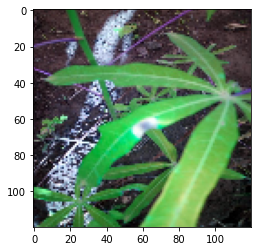

<Figure size 2400x1600 with 0 Axes>

In [11]:
show_img(zero_img[1])

In [13]:
three_img = three_img[:13000]
all_img = [zero_img,one_img,two_img,three_img,four_img]
for i in all_img:
    for j in i.copy():
        while len(i) < 13000:
            i.append(j)
    print(len(i))

13000
13000
13000
13000
13000


In [14]:
x = []
y = []
for i in zero_img:
    x.append(i)
    y.append(0)
for i in one_img:
    x.append(i)
    y.append(1)
for i in two_img:
    x.append(i)
    y.append(2)
for i in three_img:
    x.append(i)
    y.append(3)
for i in four_img:
    x.append(i)
    y.append(4)
print(len(x),len(y))

65000 65000


In [15]:
x = np.array(x)
y = np.array(y)

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=72,test_size=0.30,stratify=y)

In [17]:
x_train_scaled = x_train / 255
x_test_scaled = x_test / 255

In [18]:
x_train.shape

(45500, 120, 120, 3)

In [19]:
import tensorflow as tf
from tensorflow import keras

In [20]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [21]:
data_augment = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(120,120,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape=(120,120,3),include_top=False,weights='imagenet',pooling='max')
#import efficientnet.keras as efn
#base_model = efn.EfficientNetB0(input_shape = (160, 160, 3), weights = 'imagenet')
base_model.trainable = False

In [23]:
cnn = keras.Sequential([
    data_augment,
    base_model,
    #keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same'),
    #keras.layers.MaxPooling2D((2,2)),
    #keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
    #keras.layers.MaxPooling2D((2,2)),
    #keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
    #keras.layers.MaxPooling2D((2,2)),
    #keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
    #keras.layers.MaxPooling2D((2,2)),
    #keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
    #keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1000,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1000,activation='relu'),
    keras.layers.Dense(5,activation='softmax')
])

In [24]:
cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [25]:
cnn.fit(x_train_scaled,y_train,epochs=3,batch_size=25)

Epoch 1/3
1820/1820 [==============================] - 44s 24ms/step - loss: 0.3970 - accuracy: 0.8652
Epoch 2/3
1820/1820 [==============================] - 43s 24ms/step - loss: 0.3532 - accuracy: 0.8771
Epoch 3/3
1820/1820 [==============================] - 57s 31ms/step - loss: 0.3483 - accuracy: 0.8787


In [26]:
cnn.evaluate(x_test_scaled,y_test)

610/610 [==============================] - 120s 197ms/step - loss: 0.3271 - accuracy: 0.8852


[0.327115923166275, 0.8852307796478271]

In [ ]:
# not enough resources in my pc to evaluate the result with classification report or improve the accuracy